In [1]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
print(torch.cuda.is_available())


1
NVIDIA GeForce RTX 2050
True


In [2]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split 

In [3]:
project_name = '05-cifar10-cnn'

In [10]:
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'
airplanes_files = os.listdir(data_dir + "/train/airplane")
print(len(airplanes_files))
print(airplanes_files[:5])

5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [5]:
ship_files = os.listdir(data_dir + "/test/ship")
print(len(ship_files))
print(ship_files[:5])

1000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [6]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt  

In [7]:
# Data transforms (normalization and data augmentation)
stats = ((0.4914,0.4822,0.4465), (0.2023,0.1994,0.2010))
train_trf = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats, inplace=True)])

valid_trf = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [8]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [9]:
train_ds = ImageFolder(data_dir+'/train',train_trf)
valid_ds = ImageFolder(data_dir+'/test', valid_trf)

In [10]:
from torch.utils.data import DataLoader

batch_size = 400

In [11]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valid_ds,batch_size*2, num_workers=4, pin_memory=True)

In [12]:
from torchvision.utils import make_grid

In [16]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([]) # Disables the x and y ticks on the plot
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0)) # nrow means 1 row 8 images
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


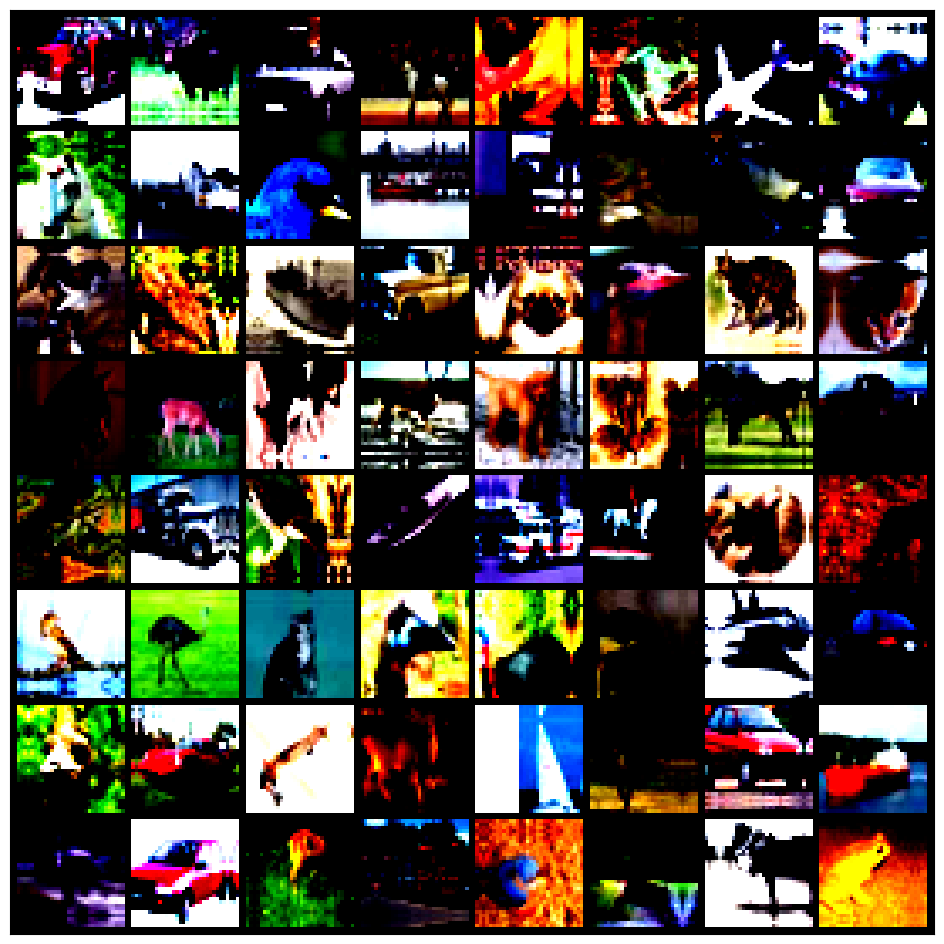

In [17]:
show_batch(train_dl)

In [31]:
def apply_kernel(image,kernel):
    ri,ci = image.shape
    rk,ck = kernel.shape
    ro,co = ri-rk+1,ci-ck+1 # 3,3 = 5-3+1, 5-3+1
    output = torch.zeros([ro,co]) # 3 x 3 matrix full of zeros
    for i in range (ro):
        for j in range (co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
sample_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size=3,stride=1,padding=1), # Hout = [(H+2*padding-kernel size)/stride +1]
    nn.MaxPool2d(2,2)                                # Wout = [(W+2*padding-kernel size)/stride +1]
)

In [35]:
for images, labels in train_dl:
    print('image shape:',images.shape)
    out = sample_model(images)
    print('out shape:', out.shape)
    break

image shape: torch.Size([128, 3, 32, 32])
out shape: torch.Size([128, 8, 16, 16])


In [19]:
class ImageClassificationBase(nn.Module):

    def training_step(self,batch):
        images , labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images , labels = batch
        out = self(images)
        loss = F.cross_entropy(out,labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss,'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'], result['val_acc']))


def accuracy (outputs,labels):
    _,preds = torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [20]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))

    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
#input = 3 x 32 x 32
        self.conv1 = conv_block(in_channels,64) # 64 x 32 x 32
        self.conv2 = conv_block(64,128,pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128,128), conv_block(128,128)) # 128 x 16 x 16

        self.conv3 = conv_block(128,256,pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256,512,pool=True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512,512), conv_block(512,512)) # 512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4), # 512 x 1 x 1
                                        nn.Flatten(), # 512
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out



In [23]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking=True)
    
        
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)

In [24]:
device = get_default_device()
device

device(type='cuda')

In [26]:
model = to_device(ResNet9(3,10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [27]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
to_device(model,device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [29]:
@torch.no_grad
def evaluate(model,val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_dl, val_dl, weight_decay=0,grad_clip=None,opt_func = torch.optim.SGD):

    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_dl))
    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        
        #Training phase
        for batch in train_dl:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            lrs.append(get_lr(optimizer))
            sched.step()

        #Validation phase
        result = evaluate(model, val_dl)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history

In [32]:
history = [evaluate(model,val_dl)]
history

[{'val_loss': 2.3048131465911865, 'val_acc': 0.09615384787321091}]

In [33]:
num_epochs = 8
max_lr= 0.01
grad_clip = 0.1
weight_decay= 1e-4
opt_func = torch.optim.Adam

In [34]:
%%time
history += fit(num_epochs,max_lr,model,train_dl,val_dl, grad_clip=grad_clip,
              weight_decay=weight_decay,opt_func=opt_func)

Epoch [0], val_loss: 1.2104, val_acc: 0.5840
Epoch [1], val_loss: 0.9492, val_acc: 0.6911
Epoch [2], val_loss: 0.6269, val_acc: 0.7916
Epoch [3], val_loss: 0.7729, val_acc: 0.7562
Epoch [4], val_loss: 0.6180, val_acc: 0.8056
Epoch [5], val_loss: 0.3763, val_acc: 0.8732
Epoch [6], val_loss: 0.3046, val_acc: 0.8954
Epoch [7], val_loss: 0.2757, val_acc: 0.9052
CPU times: total: 38 s
Wall time: 10min 58s


In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies,'-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

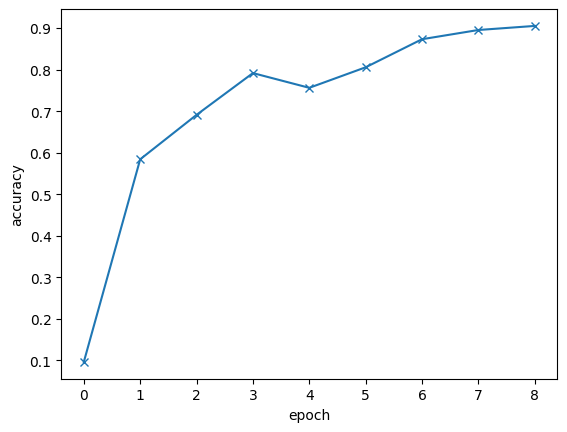

In [36]:
plot_accuracies(history)

In [37]:
def predict_image(img,model):
    xb = to_device(img.unsqueeze(0), device)

    yb = model(xb)

    _, preds = torch.max(yb, dim=1)

    return train_ds.classes[preds[0].item()]

Label: airplane Predicted: airplane


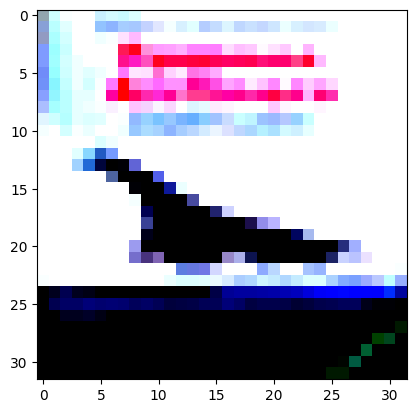

In [38]:
img, label = valid_ds[0]
plt.imshow(img.permute(1,2,0).clamp(0,1))
print('Label:', train_ds.classes[label], 'Predicted:', predict_image(img,model))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4096808..2.6952004].


Label: airplane Predicted: airplane


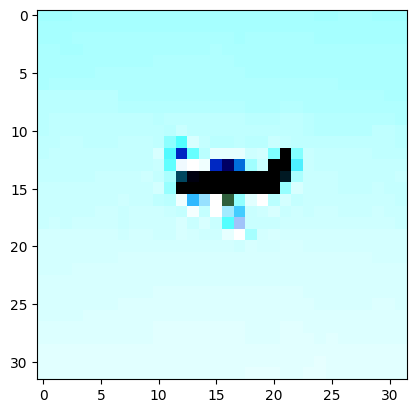

In [41]:
img, label = valid_ds[50]
plt.imshow(img.permute(1,2,0))
print('Label:', train_ds.classes[label], 'Predicted:', predict_image(img,model))

In [42]:
torch.save(model.state_dict(), 'cifar10-resnet9.pth')